In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#PDFs in BDT and sindec?
import os

# set env flags to catch BLAS used for scipy/numpy 
# to only use 1 cpu, n_cpus will be totally controlled by csky
os.environ['MKL_NUM_THREADS'] = "1"
os.environ['NUMEXPR_NUM_THREADS'] = "1"
os.environ['OMP_NUM_THREADS'] = "1"
os.environ['OPENBLAS_NUM_THREADS'] = "1"
os.environ['VECLIB_MAXIMUM_THREADS'] = "1"

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['savefig.facecolor'] = 'w'
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import csky as cy
from csky import cext
import numpy as np
import astropy
#from icecube import astro
import histlite as hl
import healpy
import pickle
import socket
healpy.disable_warnings()
plt.rc('figure', facecolor = 'w')
plt.rc('figure', dpi=100)

## Define Settings

In [2]:
selection_version = 'version-001-p00'

host_name = socket.gethostname()

if 'cobalt' in host_name:
    print('Working on Cobalts')
    data_prefix = '/data/user/ssclafani/data/cscd/final'
    ana_dir = '/data/user/ssclafani/data/analyses/'
    plot_dir = '/home/mhuennefeld/public_html/analyses/DNNCascade/plots/review/visualize_pdfs'
    
elif 'phobos' in host_name:
    print('Working on Phobos')
    data_prefix = '/net/big-tank/POOL/users/mhuennefeld/analyses/DNNCascade/data/cscd/final'
    ana_dir = '/net/big-tank/POOL/users/mhuennefeld/analyses/DNNCascade/csky/analyses/'
    plot_dir = '/home/mhuennefeld/analyses/DNNCascade/plots/review/visualize_pdfs'
    
else:
    raise ValueError('Unknown host:', host_name)

Working on Cobalts


In [3]:
for dir_path in [plot_dir]:
    if not os.path.exists(dir_path):
        print('Creating directory:', dir_path)
        os.makedirs(dir_path)

## Load Data

In [4]:
repo = cy.selections.Repository()
specs = cy.selections.DNNCascadeDataSpecs.DNNC_10yr

In [5]:
%%time

ana = cy.get_analysis(
    repo, selection_version, specs, 
    #gammas=np.r_[0.1:6.01:0.125],
)

Setting up Analysis for:
DNNCascade_10yr
Setting up DNNCascade_10yr...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86

In [6]:
a = ana.anas[0]
a.sig

Events(398873 items | columns: azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent, xdec, xra, true_dec, true_energy, true_ra, oneweight)

In [7]:
a.bg_data

Events(59610 items | columns: azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent)

## Visualize PDFs

In [8]:
from cycler import cycle

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def get_color_cycler():
    return cycle(colors)

/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


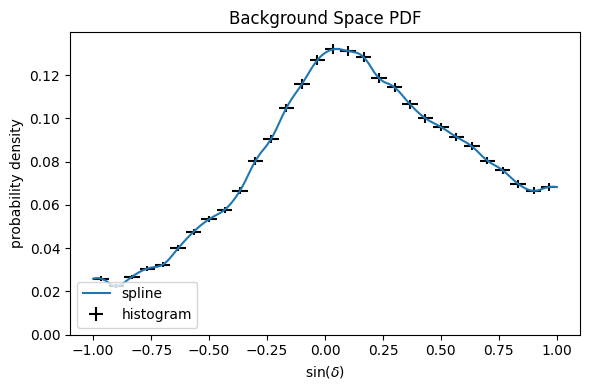

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))
hl.plot1d (ax, a.bg_space_param.h, crosses=True, color='k', label='histogram')
sd = np.linspace (-1, 1, 300)
ax.plot (sd, a.bg_space_param(sindec=sd), label='spline')
ax.set_ylim(0)
ax.set_title('Background Space PDF')
ax.set_xlabel(r'$\sin(\delta)$')
ax.set_ylabel(r'probability density')
ax.legend(loc='lower left')
plt.tight_layout()
fig.savefig(os.path.join(plot_dir, 'background_space_pdf.png'))


#### Energy PDF Ratio

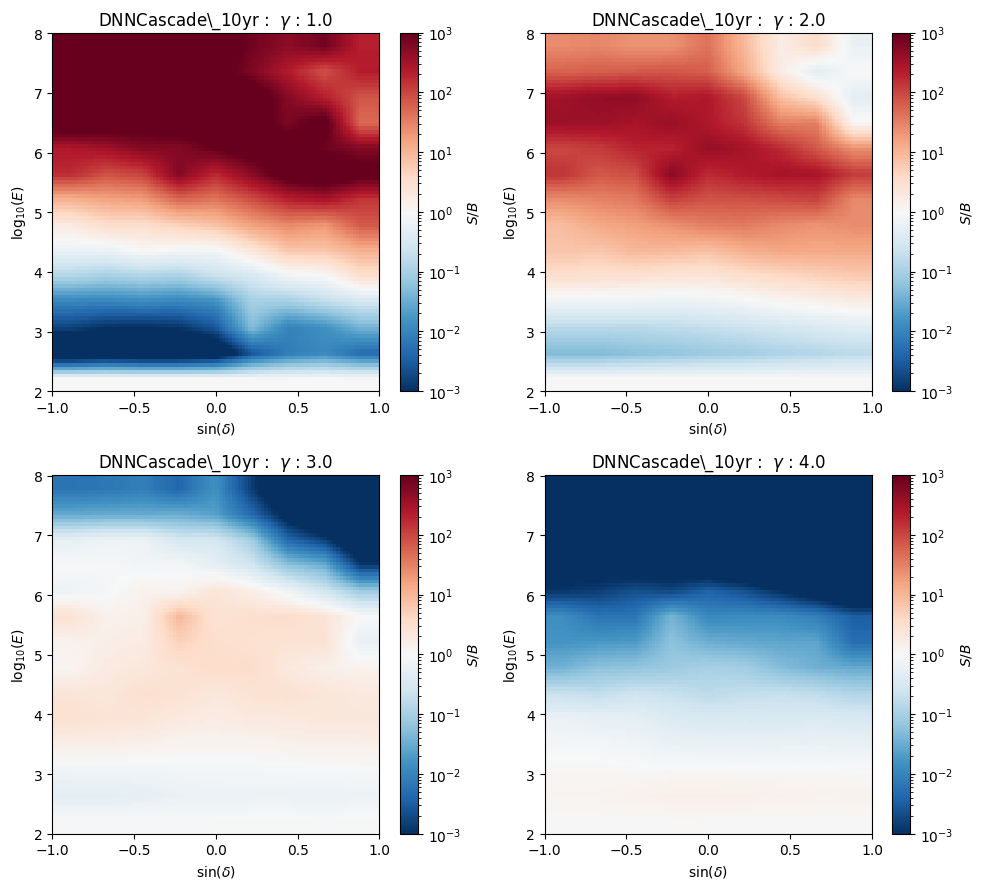

In [17]:
gammas = np.r_[1:4.01]
fig, axs = plt.subplots(2, 2, figsize=(10,9))
for (ax, gamma) in zip(axs.ravel(), gammas):
    eprm = a.energy_pdf_ratio_model
    ss = dict(zip(eprm.gammas, eprm.ss_hl))
    things = hl.plot2d(ax, ss[gamma].eval(bins=100),
                       vmin=1e-3, vmax=1e3, log=True, cbar=dict(label=r'$S/B$'), cmap='RdBu_r')
    ax.set_title('{} :  $\gamma$ : {}'.format(a.plot_key, gamma))
    ax.set_xlabel(r'sin($\delta$)')
    ax.set_ylabel(r'$\log_{10}(E)$')
plt.tight_layout()
fig.savefig(os.path.join(plot_dir, 'energy_pdf_ratio.png'))



#### 1D Energy PDF Slices

/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


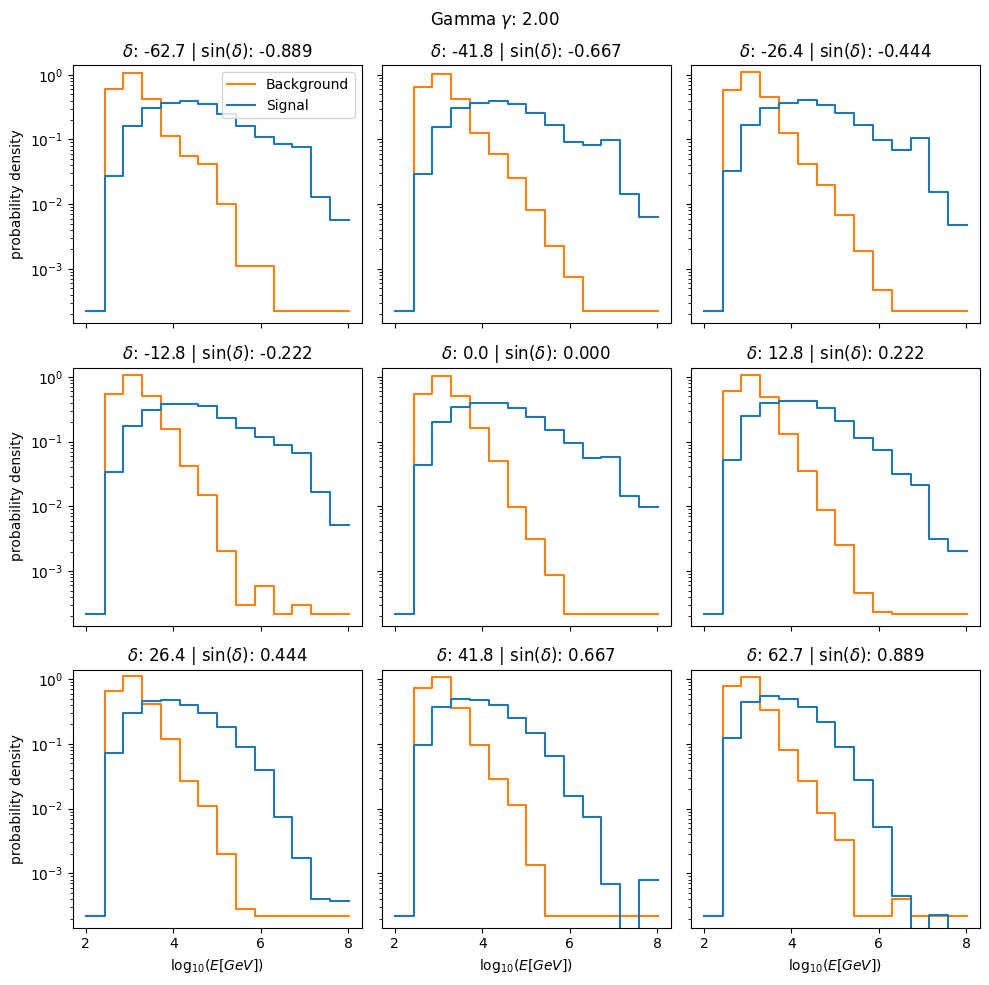

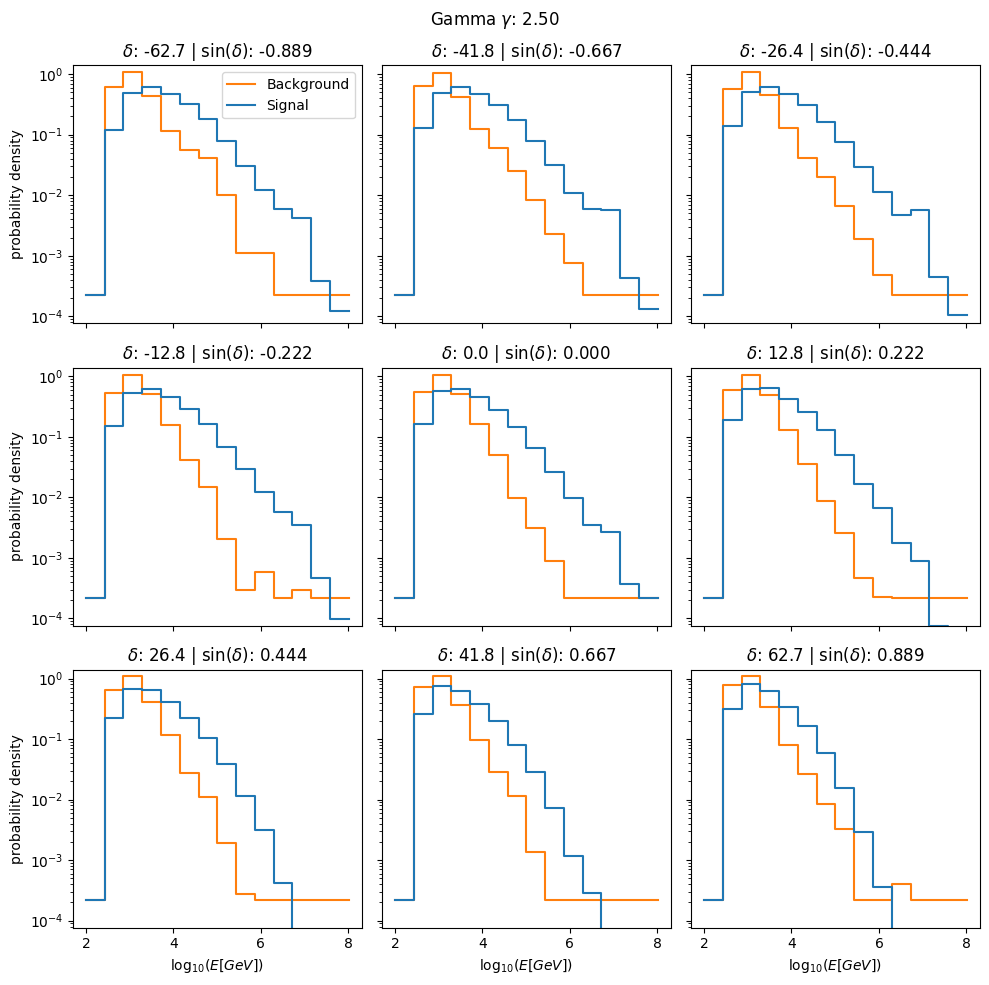

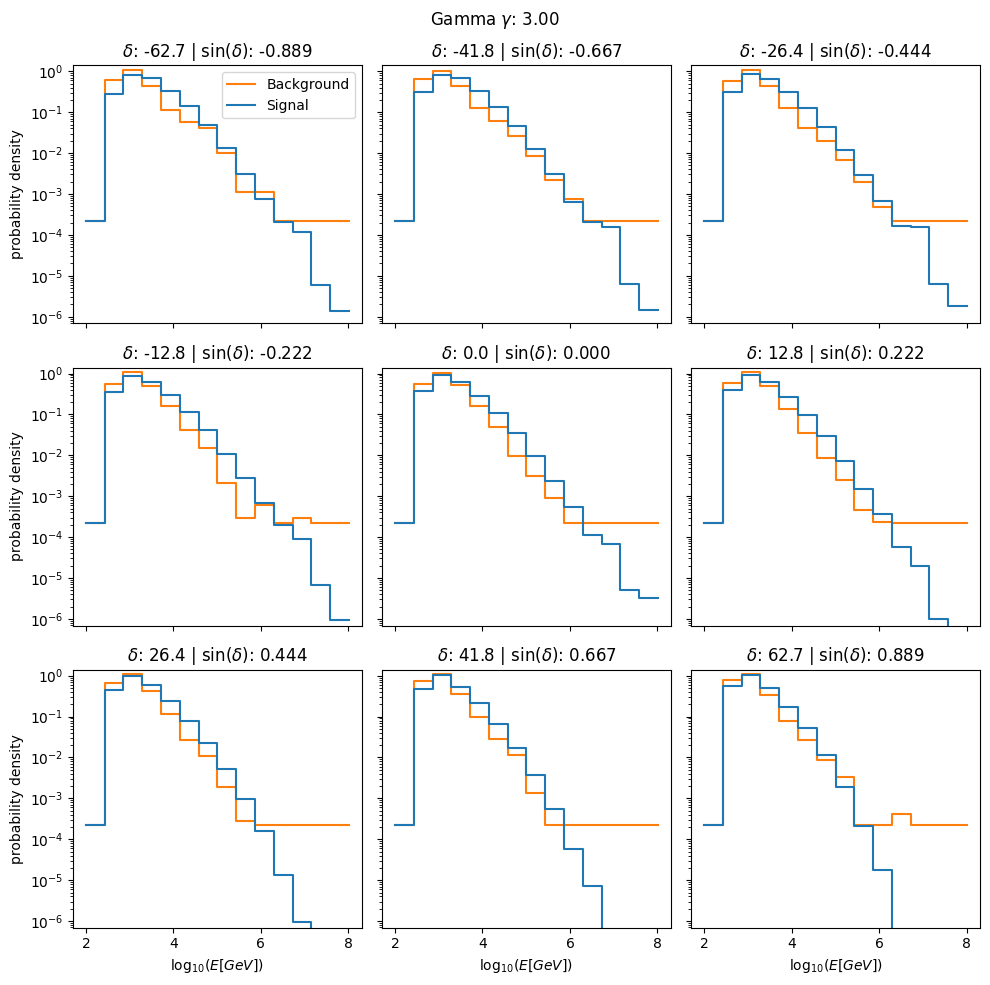

In [20]:
add_splines = False

for gamma in [2., 2.5, 3.0]:

    # get index of corresponding signal histogram
    gamma_idx = np.searchsorted(a.energy_pdf_ratio_model.gammas, gamma)

    sindec_bins = a.energy_pdf_ratio_model.hkw['bins'][0]
    sindec_mids = sindec_bins[:-1] + 0.5 * np.diff(sindec_bins)

    fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)
    for i, (ax, sindec) in enumerate(zip(axes.flatten(), sindec_mids)):
        hist_bg = a.energy_pdf_ratio_model.h_bg.get_slice(i, axis=0)
        hist_sig = a.energy_pdf_ratio_model.hs_sig[gamma_idx].get_slice(i, axis=0)
    
        
        if not add_splines:
            hl.plot1d(ax, hist_bg, crosses=False, color=colors[1], label='Background')
            hl.plot1d(ax, hist_sig, crosses=False, color=colors[0], label='Signal')
        else:
            hl.plot1d(ax, hist_bg, crosses=True, color='k')
            hl.plot1d(ax, hist_sig, crosses=True, color='k')

            x = np.linspace(2, 7.5, 300)

            # Add splines
            skw = dict(s=0, k=2, log=True)
            s_bkg = hist_bg.spline_fit(**skw).spline
            s_sig = hist_sig.spline_fit(**skw).spline

            ax.plot(x, np.exp(s_bkg(x)), color=colors[0], label='Background')
            ax.plot(x, np.exp(s_sig(x)), color=colors[1], label='Signal')
        

        ax.set_title('$\delta$: {:3.1f} | $\sin(\delta)$: {:3.3f}'.format(np.rad2deg(np.arcsin(sindec)), sindec))
        ax.set_yscale('log')

        if i == 0:
            ax.legend()
            ax.set_ylim(0, 1.4)
        
    for ax in axes[-1, :]:
        ax.set_xlabel(r'$\log_{10}(E [GeV] )$')
    for ax in axes[:, 0]:
        ax.set_ylabel('probability density')

    fig.suptitle('Gamma $\gamma$: {:3.2f}'.format(gamma))
    fig.tight_layout()
    fig.savefig(os.path.join(plot_dir, 'energy_slices_gamma_{:3.3f}.png'.format(gamma)))


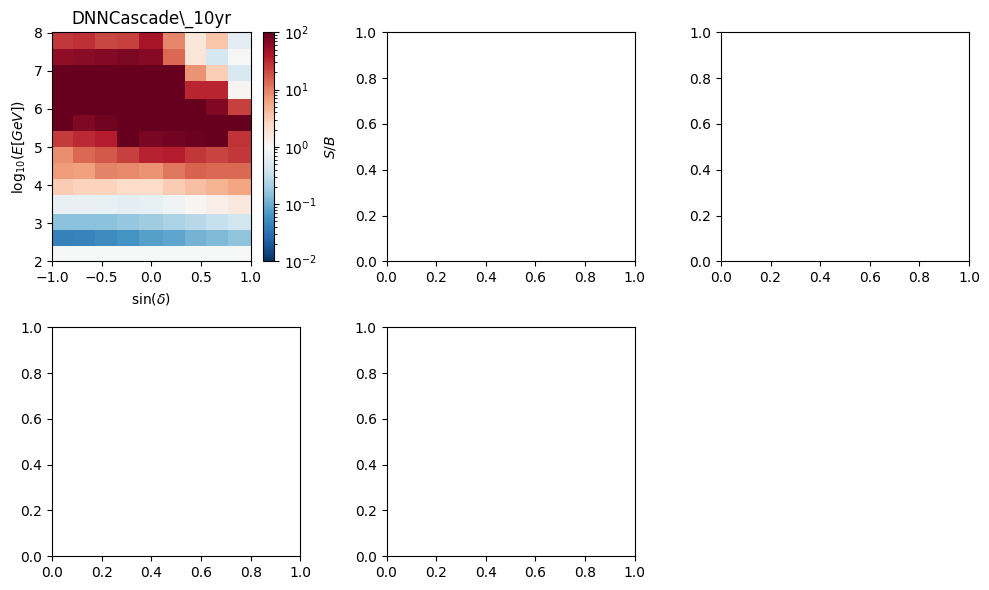

In [25]:
fig, axs = plt.subplots(2, 3, figsize=(10,6))
axs = np.ravel(axs)
for (i, a) in enumerate(ana):
    ax = axs[i]
    eprm = a.energy_pdf_ratio_model
    hs_ratio = dict(zip(eprm.gammas, eprm.hs_ratio))
    things = hl.plot2d(ax, hs_ratio[gamma].eval(bins=100),
                       vmin=1e-2, vmax=1e2, log=True, cbar=True, cmap='RdBu_r')
    ax.set_title(a.plot_key)
    things['colorbar'].set_label(r'$S/B$')
    ax.set_xlabel(r'$\sin(\delta)$')
    ax.set_ylabel(r'$\log_{10}(E[{GeV}])$')
plt.tight_layout()
axs[-1].set_visible(False)